In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import catboost
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer

from joblib import dump, load

In [2]:
data = pd.read_csv("Data/Data_Train.csv")
data.drop('Id', axis=1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Phan Loai Theo Dac Diem

def categorical_features(data):
    #Xác định các tính năng phân loại trong tập dữ liệu nhất định. 
    #Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các tính năng. 
    # Trả về: list: Danh sách các tên cột tương ứng với các đối tượng phân loại có giá trị duy nhất nhỏ hơn hoặc bằng 26.
    categorical_features = []
    for feature in data.columns:
    #Kiểm tra xem số lượng giá trị duy nhất trong đối tượng địa lý có nhỏ hơn hoặc bằng không
        if data[feature].nunique() <= 26:
            categorical_features.append(feature) #Thêm tính năng vào danh sách các tính năng được phân loại
    return categorical_features
            

In [5]:
# Dac Diem So
def numerical_features(data):
    #Xác định các đặc điểm số trong tập dữ liệu đã cho. 
    # Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các tính năng.
    # Trả về: list: Danh sách các tên cột tương ứng với các đối tượng số có giá trị duy nhất lớn hơn 26.
    numerical_features = []
    for feature in data.columns:
        #Kiểm tra xem số lượng giá trị duy nhất trong đối tượng có lớn hơn 26 không
        if data[feature].nunique() > 26:
            numerical_features.append(feature)
    return numerical_features

In [6]:
categorical_features(data)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [7]:

numerical_features(data)

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice']

In [8]:
for i, feature in enumerate(categorical_features(data)):
    missing_data = data[feature].isna().sum()
    if missing_data:
        print(f"{feature} : {data[feature].isna().sum()}")

Alley : 1369
MasVnrType : 872
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Electrical : 1
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
PoolQC : 1453
Fence : 1179
MiscFeature : 1406


In [9]:
# Bo Du Lieu Bi Thieu
def cat_drop_missing_data(data):
    #Loại bỏ các tính năng phân loại có tỷ lệ dữ liệu bị thiếu cao. 
    # Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các tính năng phân loại. 
    # Trả về: DataFrame: Tập dữ liệu đã sửa đổi với các tính năng phân loại bị xóa nếu chúng có tỷ lệ phần trăm dữ liệu bị thiếu lớn hơn 730.
    for feature in categorical_features(data): # Lặp lại thông qua các tính năng phân loại
        missing_data = data[feature].isna().sum() # Đếm dữ liệu còn thiếu cho đối tượng địa lý
        if missing_data > 730: # Kiểm tra xem phần trăm dữ liệu bị thiếu có lớn hơn 730 không
            data.drop(feature, axis=1, inplace=True) # Bỏ tính năng
    return data

In [10]:
cat_drop_missing_data(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [11]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [12]:
for i, feature in enumerate(categorical_features(data)):
    missing_data = data[feature].isna().sum()
    if missing_data:
        print(f"{feature} : {data[feature].isna().sum()}")

BsmtQual : 37


BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Electrical : 1
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81


In [13]:
# Dien Du Lieu Con Thieu
def cat_fill_missing_data(data):
    #Điền 'missing' vào các giá trị còn thiếu trong các đặc điểm phân loại. 
    # Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các tính năng phân loại. 
    # Trả về: DataFrame: Tập dữ liệu đã sửa đổi có các giá trị bị thiếu trong các tính năng phân loại được thay thế bằng 'missing'.
    for feature in categorical_features(data):
        missing_data = data[feature].isna().sum()
        if missing_data > 0:
            data[feature] = data[feature].fillna('missing')
    return data

In [14]:
cat_fill_missing_data(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [15]:
for i, feature in enumerate(categorical_features(data)):
    missing_data = data[feature].isna().sum()
    if missing_data:
        print(f"{feature} : {data[feature].isna().sum()}")

In [16]:
for i, feature in enumerate(numerical_features(data)):
    missing_data = data[feature].isna().sum()
    if missing_data:
        print(f"{feature} : {data[feature].isna().sum()}")

LotFrontage : 259
MasVnrArea : 8
GarageYrBlt : 81


In [17]:
# Dien Du Lieu So Con Thieu
def num_fill_missing_data(data):
    #Điền các giá trị còn thiếu trong các đối tượng số bằng giá trị trung bình của mỗi đối tượng. 
    # Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các đặc điểm số. 
    # Trả về: DataFrame: Tập dữ liệu đã sửa đổi có các giá trị bị thiếu trong các đối tượng số được thay thế bằng giá trị trung bình của từng đối tượng địa lý.
    for feature in numerical_features(data): # Lặp lại thông qua các tính năng số
        missing_data = data[feature].isna().sum() # Đếm dữ liệu còn thiếu cho đối tượng địa l
        if missing_data > 0:  # Kiểm tra xem có dữ liệu bị thiếu không
            data[feature] = data[feature].fillna(data[feature].median()) # Điền các giá trị còn thiếu bằng trung vị
    return data

In [18]:
num_fill_missing_data(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [20]:
for i, feature in enumerate(numerical_features(data)):
    missing_data = data[feature].isna().sum()
    if missing_data:
        print(f"{feature} : {data[feature].isna().sum()}")
        

In [21]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [22]:
#Phương thức data.describe() trong Python thường được sử dụng để cung cấp một bản tóm tắt thống kê của DataFrame, bao gồm các số liệu thống kê cơ bản như số lượng, trung bình, độ lệch chuẩn, giá trị tối thiểu và tối đa, và các phần trăm (25%, 50%, 75%).
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [23]:
#Bao Gom Ca Tuoi Cua Can Nha (Nam Ban - Nam Xay)

def include_age(data):
    # Thêm tính năng mới 'Tuổi' thể hiện tuổi của tài sản tại thời điểm bán. 
    # Tham số: data (DataFrame): Tập dữ liệu đầu vào chứa các tính năng 'YrSold' và 'YearBuilt'. 
    # Trả về: DataFrame: Tập dữ liệu đã sửa đổi với tính năng 'Age' mới được thêm vào và các cột 'YrSold' và 'YearBuilt' bị loại bỏ.
    
    
    # Tính tuổi của tài sản
    data['Age'] = data['YrSold'] - data['YearBuilt']
    # Bỏ cột 'YrSold' và 'YearBuilt' nếu chúng tồn tại
    if 'Age' in data.columns:
        data.drop(['YrSold', 'YearBuilt'], axis=1, inplace=True)
        
    return data

In [24]:
include_age(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,WD,Normal,181500,31
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,WD,Normal,223500,7
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,WD,Abnorml,140000,91
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,WD,Normal,250000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,WD,Normal,175000,8
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,WD,Normal,210000,32
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,WD,Normal,266500,69
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,WD,Normal,142125,60


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearRemo

In [26]:
categorical_features(data)

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition']

Feature Importance Analysis and One-Hot Encoding

#Feature Importance Analysis là quá trình xác định tầm quan trọng của các đặc trưng(features) trong mô hình máy học. Điều này giúp hiểu rõ hơn về các mỗi đặc trưng ảnh hưởng đến dự đoán của mô hình. Một số phương pháp phổ biến để thực hiện phân tích tầm quan trọng của đặc trưng bao gồm: 
 1. Tree-based methods: Sử dụng các mô hình cây quyết địn như Random Forest hoặc Gradient Boostinh để đánh giá tầm quan trọng của đặc trưng dựa trên tần suất và mức đồ ảnh hưởng của chúng trong quá trình xây dựng cây
 2. Permutetion Importance: Đánh giá tầm quan trọng của đặc trưng bằng các hoán đổi ngẫu nhiên giá trị của đặc trưng đó và quan sát sự thay đổi trong hiệu suất của mô hình
 3. SHAP (SHaplay Additive exPlanations): Sử dụng lý thuyết trò chơi đề phân tích tầm quan trọng của đặc trưng bằng các tính toán giá trị đóng góp của từng đặc trung vào dự đoán của mô hình

 #One-Hot Encoding là một kỹ thuật mã hóa các biến phân loại (categorical variables) thành các biến nhị phân (binary variables). Mỗi giá trị duy nhất của biến phân loại sẽ được biểu diễn bằng một cột riêng biệt trong ma trận mã hóa, với giá trị 1 nếu giá trị đó xuất hiện và 0 nếu không

1. Objective: (Mục tiêu)
Mục tiêu của phân tích này là xác định 20 tính năng quan trọng hàng đầu bằng cách sử dụng Công cụ hồi quy rừng ngẫu nhiên và sau đó áp dụng mã hóa một lần cho các tính năng này.
2. Approach: (Các tiếp cận với bài toán)
Đầu tiên, để bảo toàn dữ liệu gốc ta tạo 1 bảng sao của dữ liệu tập dữ liệu dưới dạng data_copy
 Tiếp theo, Một LabelEncoder tạm thời được khởi tạo để mã hóa các tính năng phân loại. Sau đó, các tính năng phân loại trong data_copy sẽ được sử dụng và chuyển đổi bằng LabelEncoder
 A Random Forest Regressor được train bằng cách sử dụng tập dữ liệu đã chuyển đổi (data_copy) đê xác định tầm quan trọng của tính năng
 Tầm quan trọng của các tính năng được sắp xếp theo thứ tự giảm dần để xác định 20 tính năng hàng đầu
 Cuối cùng, một biểu đồ dạng thanh được tạo ra để trực quan hóa 20 tính năng quan trọng nhất và các tính năng hàng đầu được xcas định sẽ được liệt kê

 3. Obsercations: (Quan sát)
20 tính năng hàng được được xác định được coi là rất quan trọng để hiểu tầm quan trọng của chúng trong việc dự đoán biến mục tiêu (SalePrice)
One-hot Encoding có thể được áp dụng cho các tính năng hàng đầu này để xử lý dữ liệu phân loại 1 các hiệu quả

4. Conclusion: (Kết luận)
Phân tích tầm quan trọng của tính năng cung cấp những giá trị về tập dữ liệu, hỗ trợ lựa chọn tính năng và tôi ưu hóa hiệu suất mô hình
Việc áp dụng one-hot encoding cho các tính năng phân loại sẽ nâng cap khả năng của mô hình trong việc nắm bắt các mỗi quan hệ phức tạp trong dữ liệu
    


In [27]:
data_copy = data.copy()


In [28]:
categorical_features(data_copy)

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition']

In [29]:
categorical_features(data)

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition']

In [30]:
# Khoi tao LabelEncoder
temp_labels_encoder = LabelEncoder()
# Điều chỉnh và chuyển đổi các đặc điểm phân loại trong data train 
for feature in categorical_features(data_copy):
    data_copy[feature] = temp_labels_encoder.fit_transform(data_copy[feature])

In [31]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int32  
 6   LotShape       1460 non-null   int32  
 7   LandContour    1460 non-null   int32  
 8   Utilities      1460 non-null   int32  
 9   LotConfig      1460 non-null   int32  
 10  LandSlope      1460 non-null   int32  
 11  Neighborhood   1460 non-null   int32  
 12  Condition1     1460 non-null   int32  
 13  Condition2     1460 non-null   int32  
 14  BldgType       1460 non-null   int32  
 15  HouseStyle     1460 non-null   int32  
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearRemo

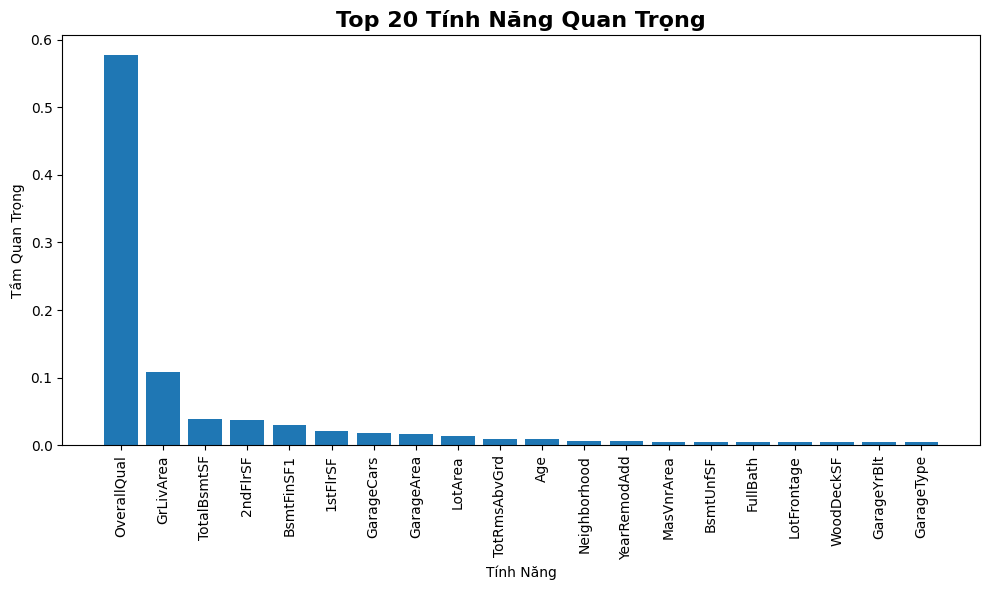

In [32]:

# Train a Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=5)
rf_regressor.fit(data_copy.drop('SalePrice', axis=1), data['SalePrice'])

# Lấy những tính năng quan trọng
feature_importances = rf_regressor.feature_importances_

# Sắp xếp tầm quan trọng của tính năng theo thứ tự giảm dần
sorted_indices = np.argsort(feature_importances)[::-1]

# Chỉ vẽ sơ đồ 5 tính năng quan trọng nhất
top_n = 20  # Số tính năng hàng đầu cần hiển thị
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[sorted_indices][:top_n], align='center')
plt.xticks(range(top_n), [data_copy.drop('SalePrice', axis=1).columns[i] for i in sorted_indices][:top_n], rotation=90)
plt.xlabel('Tính Năng')
plt.ylabel('Tầm Quan Trọng')
plt.title('Top 20 Tính Năng Quan Trọng', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [33]:
top20 = [data_copy.drop('SalePrice', axis=1).columns[i] for i in sorted_indices][:20]
top20

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 '1stFlrSF',
 'GarageCars',
 'GarageArea',
 'LotArea',
 'TotRmsAbvGrd',
 'Age',
 'Neighborhood',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtUnfSF',
 'FullBath',
 'LotFrontage',
 'WoodDeckSF',
 'GarageYrBlt',
 'GarageType']

In [34]:
def select_columns(empty_df, original_data, top_features, target_column=None):
    #Chọn các cột được chỉ định từ tập dữ liệu gốc và nối chúng vào DataFrame mới. 
    # Tham số: Empty_df (DataFrame): DataFrame trống để lưu trữ các cột đã chọn. 
    # original_data (DataFrame): Tập dữ liệu gốc. 
    # top_features (danh sách): Danh sách các tính năng hàng đầu cần chọn.
    # target_column (str hoặc None): Tên của cột mục tiêu.
    # Mặc định là Không có. 
    # returns: 
    # DataFrame: DataFrame được cập nhật với các cột đã chọn.
    
    
# Lặp lại từng tính năng hàng đầu và sao chép nó vào DataFrame trống
    for feature in top_features:
        empty_df[feature] = original_data[feature]
        
# Nếu cột mục tiêu được chỉ định, hãy sao chép nó vào DataFrame trống
    if target_column:
        empty_df[target_column] = original_data[target_column]
        
    return empty_df        

In [35]:
updated_data = pd.DataFrame()
select_columns(updated_data, data, top20, 'SalePrice')

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,...,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType,SalePrice
0,7,1710,856,854,706,856,2,548,8450,8,...,CollgCr,2003,196.0,150,2,65.0,0,2003.0,Attchd,208500
1,6,1262,1262,0,978,1262,2,460,9600,6,...,Veenker,1976,0.0,284,2,80.0,298,1976.0,Attchd,181500
2,7,1786,920,866,486,920,2,608,11250,6,...,CollgCr,2002,162.0,434,2,68.0,0,2001.0,Attchd,223500
3,7,1717,756,756,216,961,3,642,9550,7,...,Crawfor,1970,0.0,540,1,60.0,0,1998.0,Detchd,140000
4,8,2198,1145,1053,655,1145,3,836,14260,9,...,NoRidge,2000,350.0,490,2,84.0,192,2000.0,Attchd,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,953,2,460,7917,7,...,Gilbert,2000,0.0,953,2,62.0,0,1999.0,Attchd,175000
1456,6,2073,1542,0,790,2073,2,500,13175,7,...,NWAmes,1988,119.0,589,2,85.0,349,1978.0,Attchd,210000
1457,7,2340,1152,1152,275,1188,1,252,9042,9,...,Crawfor,2006,0.0,877,2,66.0,0,1941.0,Attchd,266500
1458,5,1078,1078,0,49,1078,1,240,9717,5,...,NAmes,1996,0.0,0,1,68.0,366,1950.0,Attchd,142125


In [36]:
updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   TotalBsmtSF   1460 non-null   int64  
 3   2ndFlrSF      1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   1stFlrSF      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   LotArea       1460 non-null   int64  
 9   TotRmsAbvGrd  1460 non-null   int64  
 10  Age           1460 non-null   int64  
 11  Neighborhood  1460 non-null   object 
 12  YearRemodAdd  1460 non-null   int64  
 13  MasVnrArea    1460 non-null   float64
 14  BsmtUnfSF     1460 non-null   int64  
 15  FullBath      1460 non-null   int64  
 16  LotFrontage   1460 non-null   float64
 17  WoodDeckSF    1460 non-null   int64  
 18  GarageYrBlt   1460 non-null 

In [37]:
X = updated_data.drop('SalePrice', axis=1)
y = updated_data['SalePrice']

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   TotalBsmtSF   1460 non-null   int64  
 3   2ndFlrSF      1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   1stFlrSF      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   LotArea       1460 non-null   int64  
 9   TotRmsAbvGrd  1460 non-null   int64  
 10  Age           1460 non-null   int64  
 11  Neighborhood  1460 non-null   object 
 12  YearRemodAdd  1460 non-null   int64  
 13  MasVnrArea    1460 non-null   float64
 14  BsmtUnfSF     1460 non-null   int64  
 15  FullBath      1460 non-null   int64  
 16  LotFrontage   1460 non-null   float64
 17  WoodDeckSF    1460 non-null   int64  
 18  GarageYrBlt   1460 non-null 

In [39]:
X

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,7,1710,856,854,706,856,2,548,8450,8,5,CollgCr,2003,196.0,150,2,65.0,0,2003.0,Attchd
1,6,1262,1262,0,978,1262,2,460,9600,6,31,Veenker,1976,0.0,284,2,80.0,298,1976.0,Attchd
2,7,1786,920,866,486,920,2,608,11250,6,7,CollgCr,2002,162.0,434,2,68.0,0,2001.0,Attchd
3,7,1717,756,756,216,961,3,642,9550,7,91,Crawfor,1970,0.0,540,1,60.0,0,1998.0,Detchd
4,8,2198,1145,1053,655,1145,3,836,14260,9,8,NoRidge,2000,350.0,490,2,84.0,192,2000.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,953,2,460,7917,7,8,Gilbert,2000,0.0,953,2,62.0,0,1999.0,Attchd
1456,6,2073,1542,0,790,2073,2,500,13175,7,32,NWAmes,1988,119.0,589,2,85.0,349,1978.0,Attchd
1457,7,2340,1152,1152,275,1188,1,252,9042,9,69,Crawfor,2006,0.0,877,2,66.0,0,1941.0,Attchd
1458,5,1078,1078,0,49,1078,1,240,9717,5,60,NAmes,1996,0.0,0,1,68.0,366,1950.0,Attchd


In [40]:
# Khởi tạo OneHotEncode

one_hot = OneHotEncoder()
categorical_values = categorical_features(X)
transformer = ColumnTransformer([('one_hot', one_hot, categorical_values)],
                                remainder='passthrough')
transformer_X = transformer.fit_transform(X).toarray()
X_df = pd.DataFrame(transformer_X)


In [41]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,856.0,548.0,8450.0,5.0,2003.0,196.0,150.0,65.0,0.0,2003.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1262.0,460.0,9600.0,31.0,1976.0,0.0,284.0,80.0,298.0,1976.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,920.0,608.0,11250.0,7.0,2002.0,162.0,434.0,68.0,0.0,2001.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,961.0,642.0,9550.0,91.0,1970.0,0.0,540.0,60.0,0.0,1998.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1145.0,836.0,14260.0,8.0,2000.0,350.0,490.0,84.0,192.0,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,953.0,460.0,7917.0,8.0,2000.0,0.0,953.0,62.0,0.0,1999.0
1456,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2073.0,500.0,13175.0,32.0,1988.0,119.0,589.0,85.0,349.0,1978.0
1457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1188.0,252.0,9042.0,69.0,2006.0,0.0,877.0,66.0,0.0,1941.0
1458,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1078.0,240.0,9717.0,60.0,1996.0,0.0,0.0,68.0,366.0,1950.0


Baseline Modelling (Mô Hình Cơ Sở)

In [42]:

models = {
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor()
}

In [43]:
baseline_model_mae = {}
np.random.seed(5)

for model_name, model in models.items():
    score = cross_val_score(model, 
                            X_df, 
                            y, 
                            scoring="neg_mean_absolute_error", 
                            cv=3, 
                            n_jobs=-1)
    
    baseline_model_mae[model_name] = -np.mean(score)
    
    print(f"MAE of {model_name}: {-np.mean(score)}")

MAE of RandomForest: 19124.17583025607
MAE of XGBoost: 19272.785714125388
MAE of CatBoost: 16785.0193211438


In [44]:
baseline_model_mae

{'RandomForest': 19124.17583025607,
 'XGBoost': 19272.785714125388,
 'CatBoost': 16785.0193211438}

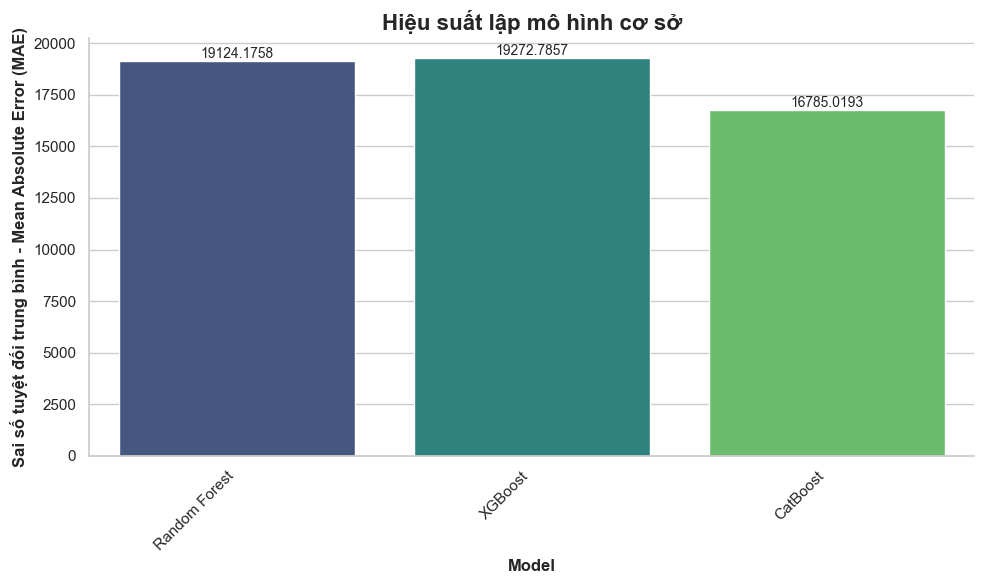

In [45]:
# Tên model tùy chỉnh và giá trị MAE
custom_model_names = ['Random Forest', 'XGBoost', 'CatBoost']
model_mae_values = list(baseline_model_mae.values())

# Đặt kiểu plot
sns.set(style='whitegrid')

# Tạo đối tượng hình và trục

fig, ax = plt.subplots(figsize=(10, 6))

#Vẽ sơ đồ thanh
sns.barplot(x=custom_model_names, y=model_mae_values, palette='viridis', ax=ax)

# Đặt tiêu đề và labels
ax.set_title('Hiệu suất lập mô hình cơ sở', fontsize = 16, fontweight = 'bold')
ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Sai số tuyệt đối trung bình - Mean Absolute Error (MAE)', fontweight='bold')

# Căn Chỉnh Trục X
plt.xticks(rotation=45, ha='right')

# Thêm label dữ liệu trên đầu thanh
for i, v in enumerate(model_mae_values):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    
#Loại bỏ các đường viền của biểu đồ
sns.despine()

#Show plot
plt.tight_layout()
plt.show()




In [46]:
#chia dữ liệu thành các tập huấn luyện và kiểm tra
X_train, X_valid, y_train, y_valid = train_test_split(X_df, y,
                                                     test_size=0.2, 
                                                     random_state=5)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((1168, 77), (292, 77), (1168,), (292,))

Hyperparameter Tuning (Điều chỉnh siêu tham số)


Random Forest
Trong Random Forest, bootstrap có nghĩa là lấy mẫu dữ liệu có thay thế để tạo nhiều tập hợp con từ tập dữ liệu gốc. Mỗi tập hợp con có cùng kích thước với dữ liệu gốc nhưng có thể chứa các bản sao và loại trừ một số trường hợp. Nó giúp xây dựng các cây quyết định đa dạng, giảm thiểu việc trang bị quá mức.


n_estimators: Số lượng cây trong rừng. 
max_deep: Độ sâu tối đa của cây. 
min_samples_split: Số lượng mẫu tối thiểu cần thiết để phân chia một nút nội bộ. 
min_samples_leaf: Số lượng mẫu tối thiểu cần có ở một nút lá. 
max_features: Số lượng tính năng cần xem xét khi tìm kiếm sự phân chia tốt nhất. 
bootstrap: Có nên khởi động mẫu khi xây dựng cây hay không. 
Random_state: Hạt giống để tạo số ngẫu nhiên, để tái tạo.


In [47]:
rf_param = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [5]
}

rf_gridcv = GridSearchCV(RandomForestRegressor(), 
                         param_grid=rf_param, 
                         cv=3, 
                         n_jobs=-1, 
                         scoring='neg_mean_absolute_error')

rf_gridcv.fit(X_train, y_train)

print(f"Thông số tốt nhất: {rf_gridcv.best_params_}")

rf_mae = -rf_gridcv.score(X_valid, y_valid)
print(f"Độ chính xác của RamdomForest (MAE): {rf_mae}")

Thông số tốt nhất: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 5}
Độ chính xác của RamdomForest (MAE): 16664.40285388128


XGBoost

learning_rate: Thu nhỏ kích thước bước được sử dụng trong bản cập nhật để ngăn chặn việc trang bị quá mức. Phạm vi: [0, 1].
n_estimators: Số vòng tăng tốc. 
max_depth: Độ sâu tối đa của cây. Giá trị cao hơn có thể dẫn đến trang bị quá mức. 
min_child_weight: Tổng trọng lượng tối thiểu (hessian) cần thiết ở trẻ. 
subsample: Tỷ lệ mẫu phụ của phiên bản huấn luyện. Phạm vi: (0, 1).
colsample_bytree: Tỷ lệ mẫu phụ của các cột khi xây dựng mỗi cây. 
reg_alpha: Thuật ngữ chính quy hóa L1 về trọng số. Có thể được sử dụng để điều chỉnh để tránh trang bị quá mức.
reg_lambda: Thuật ngữ chính quy hóa L2 trên trọng số. Có thể được sử dụng để điều chỉnh để tránh trang bị quá mức.
gamma : Cần giảm tổn thất tối thiểu để tạo thêm phân vùng trên nút lá.


In [48]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb_param = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],  # Ví dụ: chỉ định trực tiếp một phạm vi giá trị
    'min_child_weight': [1, 3, 5],  # Ví dụ: chỉ định trực tiếp một phạm vi giá trị
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5],
    'n_estimators': [100, 200, 300],  # Ví dụ: chỉ định trực tiếp một phạm vi giá trị
    'random_state': [5]
}

# Khởi tạo RandomizedSearchCV với XGBRegressor và phân phối tham số
xgb_randcv = RandomizedSearchCV(XGBRegressor(),
                                 param_distributions=xgb_param,
                                 scoring='neg_mean_absolute_error',
                                 cv=3,
                                 n_jobs=-1,
                                 n_iter=300,
                                 random_state=5)

# Huấn luyện mô hình để tìm tham số tốt nhất
xgb_randcv.fit(X_train, y_train)

# Lấy tham số tốt nhất
best_params = xgb_randcv.best_params_

# Huấn luyện lại mô hình với các tham số tốt nhất
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Dự đoán và tính MAE cho mô hình tốt nhất
y_pred = xgb_best.predict(X_valid)
xgb_mae = np.mean(np.abs(y_valid - y_pred))

# Thông số tốt nhất và điểm tốt nhất
print("Thông số tốt nhất:", best_params)
print("Độ chính xác của XGBoost (MAE):", xgb_mae)

Thông số tốt nhất: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'random_state': 5, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Độ chính xác của XGBoost (MAE): 17420.991719285103


3. CatBoost

learning_rate: Kiểm soát kích thước bước được thực hiện trong quá trình tối ưu hóa
n_estimators: Xác định số lượng cây trong quần thể
max_depth:  Chỉ định độ sâu tối đa của mỗi cây
l2_leaf_reg:  Thêm chính quy L2 vào trọng số của lá.
subsample: Phần mẫu huấn luyện được sử dụng để xây dựng từng cây.
colsample_bylevel: Tỷ lệ các đối tượng được xem xét ở mỗi cấp độ cây.
bagging_temperature: Điều chỉnh tính ngẫu nhiên trong việc lấy mẫu trong quá trình đào tạo.

In [49]:
cb_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 5, 6],
    'n_estimators': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_seed': [5]
}
# Khởi tạo RandomizedSearchCV với CatBoostRegressor và phân phối tham số
cb_gridcv = GridSearchCV(CatBoostRegressor(verbose=True, loss_function='MAE'),
                         param_grid=cb_param,
                         scoring='neg_mean_absolute_error',
                         cv=3,
                         n_jobs=-1)

#Huấn luyện mô hình
cb_gridcv.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10)

cb_mae = -cb_gridcv.best_score_

# Thông số tốt nhất và điểm tốt nhất
print("Thông số tốt nhất:", cb_gridcv.best_params_)
print(" Độ chính xác của CatBoost (MAE):", cb_mae)

0:	learn: 53665.4201313	test: 52954.0629826	best: 52954.0629826 (0)	total: 147ms	remaining: 44.1s
1:	learn: 51907.4196344	test: 51263.6042249	best: 51263.6042249 (1)	total: 155ms	remaining: 23s
2:	learn: 50015.7812523	test: 49353.6434394	best: 49353.6434394 (2)	total: 162ms	remaining: 16s
3:	learn: 48443.7177757	test: 47728.6226857	best: 47728.6226857 (3)	total: 170ms	remaining: 12.5s
4:	learn: 46967.6122326	test: 46173.7349474	best: 46173.7349474 (4)	total: 178ms	remaining: 10.5s
5:	learn: 45438.7487329	test: 44487.3940599	best: 44487.3940599 (5)	total: 186ms	remaining: 9.11s
6:	learn: 44105.7444968	test: 43091.8977263	best: 43091.8977263 (6)	total: 193ms	remaining: 8.08s
7:	learn: 42846.1852324	test: 41841.8477057	best: 41841.8477057 (7)	total: 202ms	remaining: 7.36s
8:	learn: 41665.9688906	test: 40611.2177446	best: 40611.2177446 (8)	total: 209ms	remaining: 6.74s
9:	learn: 40480.4321377	test: 39309.9375083	best: 39309.9375083 (9)	total: 216ms	remaining: 6.27s
10:	learn: 39529.0971810

In [50]:
model_mae = {
    "RandomForest": rf_mae,
    "XGBoost": xgb_mae,
    "CatBoost": cb_mae
}

model_mae

{'RandomForest': 16664.40285388128,
 'XGBoost': 17420.991719285103,
 'CatBoost': 18931.22256867973}

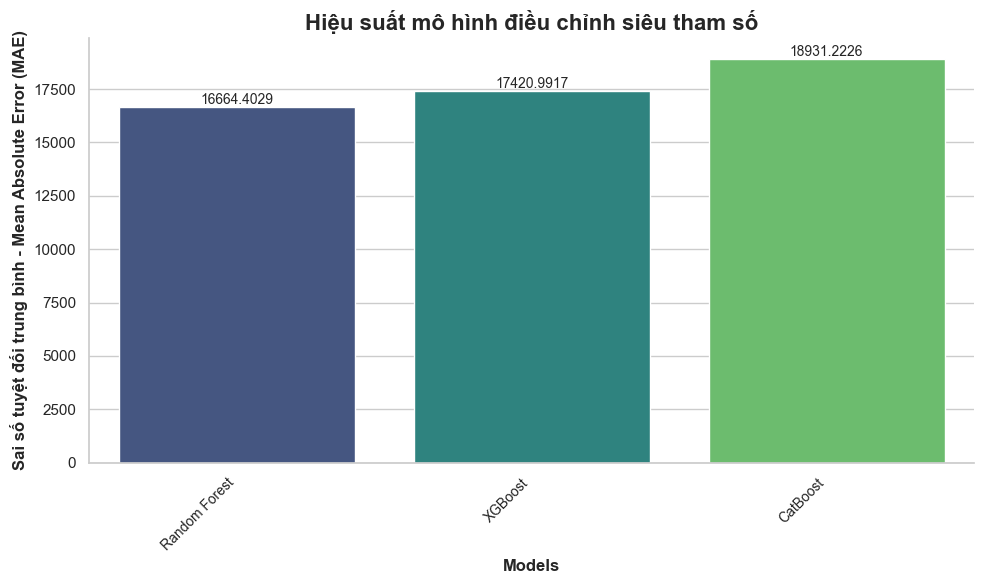

In [51]:
# Custom model names and MAE values
custom_model_names = ['Random Forest', 'XGBoost', 'CatBoost']
model_mae_values = list(model_mae.values())

# Đặt kiểu và kích thước cột
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Vẽ sơ đồ thanh
sns.barplot(x=custom_model_names, y=model_mae_values, palette='viridis')

# Set labels and title with increased font size
plt.xlabel("Models", fontweight='bold', fontsize=12)
plt.ylabel("Sai số tuyệt đối trung bình - Mean Absolute Error (MAE)", fontweight='bold', fontsize=12)
plt.title("Hiệu suất mô hình điều chỉnh siêu tham số", fontsize=16, fontweight='bold')

# Xoay trục x để dễ đọc hơn
plt.xticks(rotation=45, ha='right', fontsize=10)

# Thêm nhãn dữ liệu trên đầu thanh
for i, v in enumerate(model_mae_values):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
    
#oại bỏ các đường viền
sns.despine()

plt.tight_layout()
plt.show()

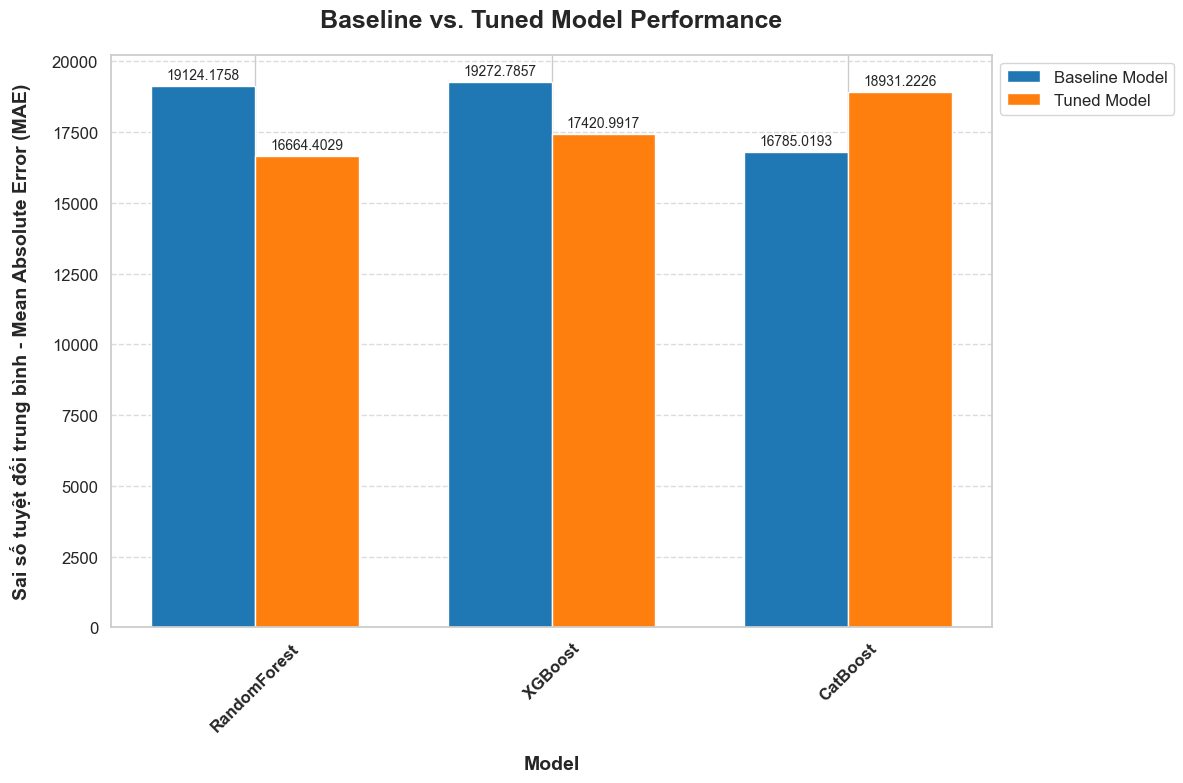

In [52]:
# Xác định dữ liệu
models = list(model_mae.keys())
baseline_scores = list(baseline_model_mae.values())
tuning_scores = list(model_mae.values())

# Đặt độ rộng của thanh
bar_width = 0.35

# Đặt vị trí x cho các nhóm
index = np.arange(len(models))

# Tạo các đối tượng hình và trục
plt.figure(figsize=(12, 8))

# Vẽ các thanh cho điểm mô hình cơ sở
bars1 = plt.bar(index, baseline_scores, bar_width, label='Baseline Model', color='#1f77b4')

# Vẽ các thanh cho điểm điều chỉnh siêu tham số
bars2 = plt.bar(index + bar_width, tuning_scores, bar_width, label='Tuned Model', color='#ff7f0e')

# Set labels and title
plt.xlabel('Model', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Sai số tuyệt đối trung bình - Mean Absolute Error (MAE)', fontsize=14, fontweight='bold', labelpad=15)
#Hiệu suất của Mô hình Cơ bản so với Mô hình Đã Tinh chỉnh
plt.title('Baseline vs. Tuned Model Performance', fontsize=18, fontweight='bold', pad=20)
plt.xticks(index + bar_width / 2, models, rotation=45, ha='center', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Add Dữ liệu mẫu
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Thêm số trên đầu thanh
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

# Thêm lưới
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Dựa trên hình ảnh trực quan, rõ ràng là RandomForestRegressor hoạt động rất tốt sau khi điều chỉnh siêu tham số. Tiếp tục sử dụng mô hình này cùng với các siêu tham số tốt nhất cho dự đoán.

In [53]:
best_model = rf_gridcv.best_estimator_
dump(best_model, "best_model.sav")

['best_model.sav']

Testing Dataset

In [54]:
data_test = pd.read_csv("./Data/Data_Test.csv")
data_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [55]:
categorical_features(data_test)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [56]:
numerical_features(data_test)

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

In [57]:
cat_drop_missing_data(data_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,2006,WD,Normal


In [58]:
cat_drop_missing_data(data_test).columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenP

In [59]:
cat_fill_missing_data(data_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,2006,WD,Normal


In [60]:
num_fill_missing_data(data_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,2006,WD,Normal


In [61]:
include_age(data_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,Age
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,WD,Normal,49
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,WD,Normal,52
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,WD,Normal,13
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,WD,Normal,12
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,WD,Normal,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,6,WD,Normal,36
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,24,0,0,0,0,0,4,WD,Abnorml,36
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,9,WD,Abnorml,46
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,32,0,0,0,0,700,7,WD,Normal,14


In [62]:
categorical_features(data_test)

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SaleType',
 'SaleCondition']

In [64]:
updated_test_data = pd.DataFrame()
select_columns(updated_test_data, data_test, top20)

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,5,896,882.0,0,468.0,896,1.0,730.0,11622,5,49,NAmes,1961,0.0,270.0,1,80.0,140,1961.0,Attchd
1,6,1329,1329.0,0,923.0,1329,1.0,312.0,14267,6,52,NAmes,1958,108.0,406.0,1,81.0,393,1958.0,Attchd
2,5,1629,928.0,701,791.0,928,2.0,482.0,13830,6,13,Gilbert,1998,0.0,137.0,2,74.0,212,1997.0,Attchd
3,6,1604,926.0,678,602.0,926,2.0,470.0,9978,7,12,Gilbert,1998,20.0,324.0,2,78.0,360,1998.0,Attchd
4,8,1280,1280.0,0,263.0,1280,2.0,506.0,5005,5,18,StoneBr,1992,0.0,1017.0,2,43.0,0,1992.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,546.0,546,0.0,546,0.0,0.0,1936,5,36,MeadowV,1970,0.0,546.0,1,21.0,0,1979.0,missing
1455,4,1092,546.0,546,252.0,546,1.0,286.0,1894,6,36,MeadowV,1970,0.0,294.0,1,21.0,0,1970.0,CarPort
1456,5,1224,1224.0,0,1224.0,1224,2.0,576.0,20000,7,46,Mitchel,1996,0.0,0.0,1,160.0,474,1960.0,Detchd
1457,5,970,912.0,0,337.0,970,0.0,0.0,10441,6,14,Mitchel,1992,0.0,575.0,1,62.0,80,1979.0,missing


In [65]:
updated_test_data

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,5,896,882.0,0,468.0,896,1.0,730.0,11622,5,49,NAmes,1961,0.0,270.0,1,80.0,140,1961.0,Attchd
1,6,1329,1329.0,0,923.0,1329,1.0,312.0,14267,6,52,NAmes,1958,108.0,406.0,1,81.0,393,1958.0,Attchd
2,5,1629,928.0,701,791.0,928,2.0,482.0,13830,6,13,Gilbert,1998,0.0,137.0,2,74.0,212,1997.0,Attchd
3,6,1604,926.0,678,602.0,926,2.0,470.0,9978,7,12,Gilbert,1998,20.0,324.0,2,78.0,360,1998.0,Attchd
4,8,1280,1280.0,0,263.0,1280,2.0,506.0,5005,5,18,StoneBr,1992,0.0,1017.0,2,43.0,0,1992.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,546.0,546,0.0,546,0.0,0.0,1936,5,36,MeadowV,1970,0.0,546.0,1,21.0,0,1979.0,missing
1455,4,1092,546.0,546,252.0,546,1.0,286.0,1894,6,36,MeadowV,1970,0.0,294.0,1,21.0,0,1970.0,CarPort
1456,5,1224,1224.0,0,1224.0,1224,2.0,576.0,20000,7,46,Mitchel,1996,0.0,0.0,1,160.0,474,1960.0,Detchd
1457,5,970,912.0,0,337.0,970,0.0,0.0,10441,6,14,Mitchel,1992,0.0,575.0,1,62.0,80,1979.0,missing


In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   TotalBsmtSF   1460 non-null   int64  
 3   2ndFlrSF      1460 non-null   int64  
 4   BsmtFinSF1    1460 non-null   int64  
 5   1stFlrSF      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   LotArea       1460 non-null   int64  
 9   TotRmsAbvGrd  1460 non-null   int64  
 10  Age           1460 non-null   int64  
 11  Neighborhood  1460 non-null   object 
 12  YearRemodAdd  1460 non-null   int64  
 13  MasVnrArea    1460 non-null   float64
 14  BsmtUnfSF     1460 non-null   int64  
 15  FullBath      1460 non-null   int64  
 16  LotFrontage   1460 non-null   float64
 17  WoodDeckSF    1460 non-null   int64  
 18  GarageYrBlt   1460 non-null 

In [67]:
updated_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   TotalBsmtSF   1459 non-null   float64
 3   2ndFlrSF      1459 non-null   int64  
 4   BsmtFinSF1    1459 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   GarageCars    1459 non-null   object 
 7   GarageArea    1459 non-null   float64
 8   LotArea       1459 non-null   int64  
 9   TotRmsAbvGrd  1459 non-null   int64  
 10  Age           1459 non-null   int64  
 11  Neighborhood  1459 non-null   object 
 12  YearRemodAdd  1459 non-null   int64  
 13  MasVnrArea    1459 non-null   float64
 14  BsmtUnfSF     1459 non-null   float64
 15  FullBath      1459 non-null   int64  
 16  LotFrontage   1459 non-null   float64
 17  WoodDeckSF    1459 non-null   int64  
 18  GarageYrBlt   1459 non-null 

In [68]:
categorical_features(updated_test_data)

['OverallQual',
 'GarageCars',
 'TotRmsAbvGrd',
 'Neighborhood',
 'FullBath',
 'GarageType']

In [69]:
categorical_features(X)

['OverallQual',
 'GarageCars',
 'TotRmsAbvGrd',
 'Neighborhood',
 'FullBath',
 'GarageType']

In [70]:
X

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,7,1710,856,854,706,856,2,548,8450,8,5,CollgCr,2003,196.0,150,2,65.0,0,2003.0,Attchd
1,6,1262,1262,0,978,1262,2,460,9600,6,31,Veenker,1976,0.0,284,2,80.0,298,1976.0,Attchd
2,7,1786,920,866,486,920,2,608,11250,6,7,CollgCr,2002,162.0,434,2,68.0,0,2001.0,Attchd
3,7,1717,756,756,216,961,3,642,9550,7,91,Crawfor,1970,0.0,540,1,60.0,0,1998.0,Detchd
4,8,2198,1145,1053,655,1145,3,836,14260,9,8,NoRidge,2000,350.0,490,2,84.0,192,2000.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,953,2,460,7917,7,8,Gilbert,2000,0.0,953,2,62.0,0,1999.0,Attchd
1456,6,2073,1542,0,790,2073,2,500,13175,7,32,NWAmes,1988,119.0,589,2,85.0,349,1978.0,Attchd
1457,7,2340,1152,1152,275,1188,1,252,9042,9,69,Crawfor,2006,0.0,877,2,66.0,0,1941.0,Attchd
1458,5,1078,1078,0,49,1078,1,240,9717,5,60,NAmes,1996,0.0,0,1,68.0,366,1950.0,Attchd


In [71]:
updated_test_data

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,5,896,882.0,0,468.0,896,1.0,730.0,11622,5,49,NAmes,1961,0.0,270.0,1,80.0,140,1961.0,Attchd
1,6,1329,1329.0,0,923.0,1329,1.0,312.0,14267,6,52,NAmes,1958,108.0,406.0,1,81.0,393,1958.0,Attchd
2,5,1629,928.0,701,791.0,928,2.0,482.0,13830,6,13,Gilbert,1998,0.0,137.0,2,74.0,212,1997.0,Attchd
3,6,1604,926.0,678,602.0,926,2.0,470.0,9978,7,12,Gilbert,1998,20.0,324.0,2,78.0,360,1998.0,Attchd
4,8,1280,1280.0,0,263.0,1280,2.0,506.0,5005,5,18,StoneBr,1992,0.0,1017.0,2,43.0,0,1992.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,546.0,546,0.0,546,0.0,0.0,1936,5,36,MeadowV,1970,0.0,546.0,1,21.0,0,1979.0,missing
1455,4,1092,546.0,546,252.0,546,1.0,286.0,1894,6,36,MeadowV,1970,0.0,294.0,1,21.0,0,1970.0,CarPort
1456,5,1224,1224.0,0,1224.0,1224,2.0,576.0,20000,7,46,Mitchel,1996,0.0,0.0,1,160.0,474,1960.0,Detchd
1457,5,970,912.0,0,337.0,970,0.0,0.0,10441,6,14,Mitchel,1992,0.0,575.0,1,62.0,80,1979.0,missing


Xử lý các danh mục bổ sung trong tính năng phân loại

Các bước sau đây đã được thực hiện để xử lý các danh mục bổ sung có trong một số tính năng phân loại của dữ liệu thử nghiệm (update_test_data) không có trong dữ liệu huấn luyện (X):

1. Identifying Additional Categories: (Xác định các danh mục bổ sung)

Đầu tiên, xác định các tính năng phân loại và so sánh các danh mục duy nhất của chúng giữa dữ liệu huấn luyện và kiểm tra.

Các tính năng như GarageCars, TotRmsAbvGrd và FullBath được phát hiện có các danh mục bổ sung trong dữ liệu thử nghiệm so với dữ liệu đào tạo.

2. Handling Additional Categories: (Xử lý các danh mục bổ sung)


GarageCars: Chúng tôi đã thay thế các danh mục bổ sung 'missing' và 5.0 bằng các giá trị thích hợp (tương ứng là 2.0 và 4.0). 
Điều này được thực hiện để đảm bảo tính nhất quán và tương thích với dữ liệu huấn luyện.


TotRmsAbvGrd: Chúng tôi đã thay thế danh mục 13 và 15 bổ sung bằng giá trị chung 12. 
Việc đơn giản hóa này giúp duy trì tính nhất quán của tính năng trên dữ liệu đào tạo và kiểm tra.


FullBath: Chúng tôi đã thay thế danh mục 4 bổ sung bằng giá trị 3. 
Tương tự như các tính năng khác, điều này đảm bảo tính nhất quán trong các danh mục giữa dữ liệu đào tạo và kiểm tra.





3. Kết luận

Lý do cho việc tiền xử lý này là để đảm bảo rằng dữ liệu thử nghiệm tuân theo cùng định dạng và danh mục như dữ liệu huấn luyện.

Các mô hình học máy được đào tạo dựa trên dữ liệu đào tạo và đưa ra dự đoán dựa trên các mẫu đã học được trong quá trình đào tạo.

Nếu dữ liệu thử nghiệm chứa các danh mục không được nhìn thấy trong quá trình đào tạo, điều đó có thể dẫn đến sai sót hoặc sự không nhất quán trong dự đoán.


Do đó, bằng cách xử lý các danh mục bổ sung trong dữ liệu thử nghiệm, chúng tôi đảm bảo rằng mô hình có thể đưa ra dự đoán chính xác khi triển khai trên dữ liệu mới, chưa được xem.



In [72]:
for i in categorical_features(X):
    print(i, X[i].nunique())

OverallQual 10
GarageCars 5
TotRmsAbvGrd 12
Neighborhood 25
FullBath 4
GarageType 7


In [73]:
for i in categorical_features(updated_test_data):
    print(i, updated_test_data[i].nunique())

OverallQual 10
GarageCars 7
TotRmsAbvGrd 12
Neighborhood 25
FullBath 5
GarageType 7


In [75]:
# Lấy danh sách các tính năng phân loại
categorical_features_train = categorical_features(X)
categorical_features_test = categorical_features(updated_test_data)

# Lặp lại qua từng tính năng phân loại và so sánh các danh mục duy nhất
for feature in categorical_features_train:
    unique_categories_train = set(X[feature].unique())
    unique_categories_test = set(updated_test_data[feature].unique())
    
    additional_categories = unique_categories_test - unique_categories_train
    
    if additional_categories:
        print(f"Các danh mục bổ sung trong '{feature}': {additional_categories}")


Các danh mục bổ sung trong 'GarageCars': {'missing', 5.0}
Các danh mục bổ sung trong 'TotRmsAbvGrd': {13, 15}
Các danh mục bổ sung trong 'FullBath': {4}


In [76]:
X['GarageCars'].value_counts()

GarageCars
2    824
1    369
3    181
0     81
4      5
Name: count, dtype: int64

In [77]:
updated_test_data['GarageCars'].value_counts()

GarageCars
2.0        770
1.0        407
3.0        193
0.0         76
4.0         11
5.0          1
missing      1
Name: count, dtype: int64

In [78]:
X['TotRmsAbvGrd'].value_counts()

TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64

In [79]:
updated_test_data['TotRmsAbvGrd'].value_counts()


TotRmsAbvGrd
6     442
7     320
5     308
8     160
4      99
9      68
10     33
11     14
3       8
12      5
13      1
15      1
Name: count, dtype: int64

In [80]:
X['FullBath'].value_counts()

FullBath
2    768
1    650
3     33
0      9
Name: count, dtype: int64

In [81]:
updated_test_data['FullBath'].value_counts()

FullBath
2    762
1    659
3     31
4      4
0      3
Name: count, dtype: int64

In [82]:
# For GarageCars
updated_test_data['GarageCars'] = updated_test_data['GarageCars'].replace('missing', 2.0)
updated_test_data['GarageCars'] = updated_test_data['GarageCars'].replace(5.0, 4.0)

# For TotRmsAbvGrd
updated_test_data['TotRmsAbvGrd'] = updated_test_data['TotRmsAbvGrd'].replace({13: 12, 15: 12})

# For FullBath
updated_test_data['FullBath'] = updated_test_data['FullBath'].replace(4, 3)

In [83]:
X['GarageCars'].value_counts()


GarageCars
2    824
1    369
3    181
0     81
4      5
Name: count, dtype: int64

In [84]:
updated_test_data['GarageCars'].value_counts()

GarageCars
2.0    771
1.0    407
3.0    193
0.0     76
4.0     12
Name: count, dtype: int64

In [85]:
X['TotRmsAbvGrd'].value_counts()

TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64

In [86]:
updated_test_data['TotRmsAbvGrd'].value_counts()

TotRmsAbvGrd
6     442
7     320
5     308
8     160
4      99
9      68
10     33
11     14
3       8
12      7
Name: count, dtype: int64

In [87]:
X['FullBath'].value_counts()

FullBath
2    768
1    650
3     33
0      9
Name: count, dtype: int64

In [88]:
updated_test_data['FullBath'].value_counts()


FullBath
2    762
1    659
3     35
0      3
Name: count, dtype: int64

In [93]:
def transform_data(transformer, data):
    #Chuyển đổi dữ liệu đầu vào bằng cách sử dụng biến áp được chỉ định và trả về DataFrame. 
    # Tham số: Transformer (ColumnTransformer): Là đối tượng ColumnTransformer được trang bị. 
    # data (DataFrame): Dữ liệu đầu vào cần chuyển đổi. 
    # Return: DataFrame: Dữ liệu được chuyển đổi dưới dạng DataFrame.
    
    
    # Chuyển đổi dữ liệu đầu vào bằng bộ chuyển đổi được chỉ định
    transform_X = transformer.transform(data).toarray()
    
    # Tạo DataFrame từ dữ liệu được chuyển đổi
    transformed_df = pd.DataFrame(transform_X)
    
    return transformed_df


In [94]:
# Chuyển đổi updated_test_data
updated_test_data_df = transform_data(transformer, updated_test_data)
updated_test_data_df

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,896.0,730.0,11622.0,49.0,1961.0,0.0,270.0,80.0,140.0,1961.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1329.0,312.0,14267.0,52.0,1958.0,108.0,406.0,81.0,393.0,1958.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,928.0,482.0,13830.0,13.0,1998.0,0.0,137.0,74.0,212.0,1997.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,926.0,470.0,9978.0,12.0,1998.0,20.0,324.0,78.0,360.0,1998.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1280.0,506.0,5005.0,18.0,1992.0,0.0,1017.0,43.0,0.0,1992.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,546.0,0.0,1936.0,36.0,1970.0,0.0,546.0,21.0,0.0,1979.0
1455,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,546.0,286.0,1894.0,36.0,1970.0,0.0,294.0,21.0,0.0,1970.0
1456,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1224.0,576.0,20000.0,46.0,1996.0,0.0,0.0,160.0,474.0,1960.0
1457,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,970.0,0.0,10441.0,14.0,1992.0,0.0,575.0,62.0,80.0,1979.0


In [95]:
baseline_model_mae


{'RandomForest': 19124.17583025607,
 'XGBoost': 19272.785714125388,
 'CatBoost': 16785.0193211438}

In [96]:
model_mae


{'RandomForest': 16664.40285388128,
 'XGBoost': 17420.991719285103,
 'CatBoost': 18931.22256867973}

Target prediction
(Mục Tiêu Dự Đoán)

In [97]:
best_model

RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=150,
                      random_state=5)

In [98]:
test_preds = best_model.predict(updated_test_data_df)
test_preds = pd.DataFrame(test_preds, columns=['SalePrice'])
test_preds

,SalePrice
0,131072.666667
1,159903.333333
2,184930.133333
3,185226.266667
4,187920.966667
...,...
1454,85307.333333
1455,85128.000000
1456,166305.053333
1457,109049.666667


Sample Submission
(Gửi Mẫu)

In [100]:
submission = pd.concat([data_test['Id'],test_preds], axis=1)
submission

,Id,SalePrice
0,1461,131072.666667
1,1462,159903.333333
2,1463,184930.133333
3,1464,185226.266667
4,1465,187920.966667
...,...,...
1454,2915,85307.333333
1455,2916,85128.000000
1456,2917,166305.053333
1457,2918,109049.666667


In [101]:
submission.to_csv("submission.csv", index=False)


In [102]:
dump(best_model, "best_model.sav")


['best_model.sav']

In [103]:
for i in categorical_features(updated_test_data):
    print(data[i].value_counts())
    print("--"*20)

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64
----------------------------------------
GarageCars
2    824
1    369
3    181
0     81
4      5
Name: count, dtype: int64
----------------------------------------
TotRmsAbvGrd
6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: count, dtype: int64
----------------------------------------
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64
----------------------------------------
FullBath
2    768
1    650
3     33
0      

In [104]:
updated_test_data.to_csv('sample.csv', index=False)


In [105]:
X.to_csv('updated_X.csv', index=False)


In [106]:
X

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,7,1710,856,854,706,856,2,548,8450,8,5,CollgCr,2003,196.0,150,2,65.0,0,2003.0,Attchd
1,6,1262,1262,0,978,1262,2,460,9600,6,31,Veenker,1976,0.0,284,2,80.0,298,1976.0,Attchd
2,7,1786,920,866,486,920,2,608,11250,6,7,CollgCr,2002,162.0,434,2,68.0,0,2001.0,Attchd
3,7,1717,756,756,216,961,3,642,9550,7,91,Crawfor,1970,0.0,540,1,60.0,0,1998.0,Detchd
4,8,2198,1145,1053,655,1145,3,836,14260,9,8,NoRidge,2000,350.0,490,2,84.0,192,2000.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,694,0,953,2,460,7917,7,8,Gilbert,2000,0.0,953,2,62.0,0,1999.0,Attchd
1456,6,2073,1542,0,790,2073,2,500,13175,7,32,NWAmes,1988,119.0,589,2,85.0,349,1978.0,Attchd
1457,7,2340,1152,1152,275,1188,1,252,9042,9,69,Crawfor,2006,0.0,877,2,66.0,0,1941.0,Attchd
1458,5,1078,1078,0,49,1078,1,240,9717,5,60,NAmes,1996,0.0,0,1,68.0,366,1950.0,Attchd


In [107]:
categorical_features(X)


['OverallQual',
 'GarageCars',
 'TotRmsAbvGrd',
 'Neighborhood',
 'FullBath',
 'GarageType']

In [108]:
updated_test_data

,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,GarageCars,GarageArea,LotArea,TotRmsAbvGrd,Age,Neighborhood,YearRemodAdd,MasVnrArea,BsmtUnfSF,FullBath,LotFrontage,WoodDeckSF,GarageYrBlt,GarageType
0,5,896,882.0,0,468.0,896,1.0,730.0,11622,5,49,NAmes,1961,0.0,270.0,1,80.0,140,1961.0,Attchd
1,6,1329,1329.0,0,923.0,1329,1.0,312.0,14267,6,52,NAmes,1958,108.0,406.0,1,81.0,393,1958.0,Attchd
2,5,1629,928.0,701,791.0,928,2.0,482.0,13830,6,13,Gilbert,1998,0.0,137.0,2,74.0,212,1997.0,Attchd
3,6,1604,926.0,678,602.0,926,2.0,470.0,9978,7,12,Gilbert,1998,20.0,324.0,2,78.0,360,1998.0,Attchd
4,8,1280,1280.0,0,263.0,1280,2.0,506.0,5005,5,18,StoneBr,1992,0.0,1017.0,2,43.0,0,1992.0,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,546.0,546,0.0,546,0.0,0.0,1936,5,36,MeadowV,1970,0.0,546.0,1,21.0,0,1979.0,missing
1455,4,1092,546.0,546,252.0,546,1.0,286.0,1894,6,36,MeadowV,1970,0.0,294.0,1,21.0,0,1970.0,CarPort
1456,5,1224,1224.0,0,1224.0,1224,2.0,576.0,20000,7,46,Mitchel,1996,0.0,0.0,1,160.0,474,1960.0,Detchd
1457,5,970,912.0,0,337.0,970,0.0,0.0,10441,6,14,Mitchel,1992,0.0,575.0,1,62.0,80,1979.0,missing


In [109]:
pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: d:\Vsvode\Python\DuDoanGiaNha - Main\.venv\Lib\site-packages
Requires: 
Required-by: scikit-learn
Note: you may need to restart the kernel to use updated packages.
